In [1]:
import os, sys
import plac
import shutil
import warnings
import datetime
import numpy as np
import pandas as pd
from time import time
from astropy import wcs
import concurrent.futures
from dateutil import parser
from astropy.io import fits
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats as scs
warnings.simplefilter('ignore')

In [2]:
from limepy import limepy

In [3]:
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.5, rc={'ytick.left': True,
                                               'xtick.bottom': True,
                                               })

In [4]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, LogFormatter, ScalarFormatter, LogLocator, FuncFormatter, MaxNLocator

In [5]:
df = pd.read_csv("n6.csv")

In [6]:
odf = pd.read_csv("N6752_all_v4.csv")

In [6]:
ra0,dec0 = 287.715745, -59.981851

gap_height=0.016

gap2_ldec=-60.381
gap2_udec = gap2_ldec + gap_height

gap1_ldec=-59.872
gap1_udec = gap1_ldec + gap_height

r_min, r_max = odf["RA"].min(), odf["RA"].max()

d_min, d_max = odf["DEC"].min(), odf["DEC"].max()

In [7]:
step = 5/3600

In [8]:
decs1 = np.arange(d_min, gap2_ldec+step, step)
decs2 = np.arange(gap2_udec, gap1_ldec+step, step)
decs3 = np.arange(gap1_udec, d_max+step,  step)

decs = np.append(decs1, decs2)
decs = np.append(decs, decs3)

In [9]:
ras = np.arange(r_min, r_max, step)

In [10]:
grid = []

[grid.append([ra,dec]) for ra in ras for dec in decs ];        

In [11]:
R = np.array(grid).T[0]
D = np.array(grid).T[1]

In [12]:
rd = pd.DataFrame({"R":R, "D":D})

In [13]:
def get_dist(x):
    x1 = (x[0] -ra0)*np.cos(x[1]/180*3.14159265359)
    y1 = x[1] - dec0
    return np.sqrt(x1**2 + y1**2)

In [14]:
#%%timeit -n 1 -r 1
rd["ds"] = rd.apply(lambda x: get_dist(x), axis=1)

In [15]:
rd1 = rd.copy(True)

In [16]:
rd["ds"] = rd["ds"]*60.

In [17]:
area_bins = pd.cut(rd["ds"], np.logspace(-1,np.log10(50), num=100))

In [18]:
rdg = rd.groupby(area_bins).agg({"D": "mean", "ds":"count"})

In [19]:
rdg["area_alg"] = rdg["ds"]*step**2*(np.abs(np.cos(rdg["D"]/180*np.pi)))*3600

In [20]:
rdg["area_norm"] = [np.pi*(rdg.index[i].right**2 - rdg.index[i].left**2) for i in range(len(rdg.index))]

In [21]:
rdg["radii"] = [np.sqrt((rdg.index[i].right**2 + rdg.index[i].left**2)/2) for i in range(len(rdg.index))]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


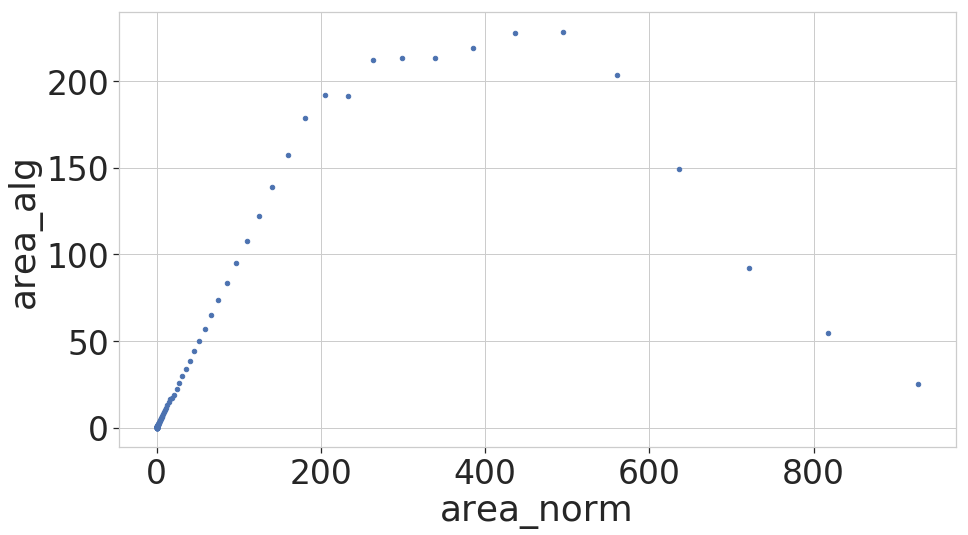

In [22]:
rdg.plot("area_norm", "area_alg",  "scatter", figsize=(15,8));

In [23]:
df1 = df[["ID", "RA", "DEC" , "DIST"]]

r = pd.cut(df1["DIST"], np.logspace(-1,np.log10(50), num=100)) #np.arange(0.0,50.0,0.1))

df2 = df1.groupby(r).count()

In [24]:
df2["ind"]=df2.index
df2["mids"] = df2["ind"].apply(lambda x : x.mid)
df2.drop("ind", axis=1, inplace=True)
df2.head()

,ID,RA,DEC,DIST,mids
DIST,,,,,
"(0.1, 0.106]",1,1,1,1,0.1030
"(0.106, 0.113]",0,0,0,0,0.1095
"(0.113, 0.121]",1,1,1,1,0.1170
"(0.121, 0.129]",0,0,0,0,0.1250
"(0.129, 0.137]",0,0,0,0,0.1330


In [25]:
df3 = df2.join(rdg, sort=False)

In [26]:
df3["lin_err"] = np.sqrt(df3.ID)/df3["area_alg"].values
df3["lin_y"] = (df3.ID)/df3["area_alg"].values

In [27]:
df3["radii"] = df3["radii"]*60

In [28]:
df3.head()

,ID,RA,DEC,DIST,mids,D,ds,area_alg,area_norm,radii,lin_err,lin_y
DIST,,,,,,,,,,,,
"(0.1, 0.106]",1,1,1,1,0.1030,-59.981667,2,0.006948,0.003883,6.182621,143.920244,143.920244
"(0.106, 0.113]",0,0,0,0,0.1095,-59.980278,1,0.003474,0.004816,6.573355,0.000000,0.000000
"(0.113, 0.121]",1,1,1,1,0.1170,-59.980278,1,0.003474,0.005881,7.024101,287.828413,287.828413
"(0.121, 0.129]",0,0,0,0,0.1250,-59.983056,2,0.006948,0.006283,7.503839,0.000000,0.000000
"(0.129, 0.137]",0,0,0,0,0.1330,NaN,0,NaN,0.006685,7.983608,NaN,NaN


In [7]:
df3 = pd.read_csv("ND_intermediate.csv")

In [8]:
cond = df3["radii"]<300

In [9]:
df4 = df3[cond]

In [10]:
x2 = df4.radii.values
y2 = df4.lin_y.values
y_err2 = df4.lin_err.values    #np.sqrt(y)/y#df2["err"].values

In [11]:
df5 = df3[~cond]

In [12]:
x1 = df5.radii.values
y1 = df5.lin_y.values
y_err1 = df5.lin_err.values   

In [13]:
df6 = df3[df3["radii"]>900]

In [14]:
x3 = df6.radii.values
y3 = df6.lin_y.values
y_err3 = df6.lin_err.values   

## ND profile

In [15]:
def log(x):
    return np.log10(x)

In [16]:
t2=pd.read_csv("trager_2.dat", delim_whitespace=True,header=None, usecols=[1,2], names=["logr", "sb"])

r = t2["logr"]

nd = t2["sb"]/-2.5-log(3600)+15-0.75

#plt.scatter(r, nd, c='k', s=5)
#plt.ylim(11,2)


 Model properties: 
 ----------------- 
 phi0 =  8.80; g = 1.00
 Converged = True
 M =  6.218e+01; U = -1.008e+02; K = 5.038e+01; Q = 0.5000;  2Kr/Kt = 1.000
 rv/rh = 1.042; rh/r0 = 13.185; rt/r0 = 116.352; ra/rh = 7584506.440

 Model properties: 
 ----------------- 
 phi0 =  6.80; g = 2.00
 Converged = True
 M =  2.283e+01; U = -3.595e+01; K = 1.797e+01; Q = 0.5000;  2Kr/Kt = 1.000
 rv/rh = 1.303; rh/r0 =  3.987; rt/r0 = 174.030; ra/rh = 25084324.292


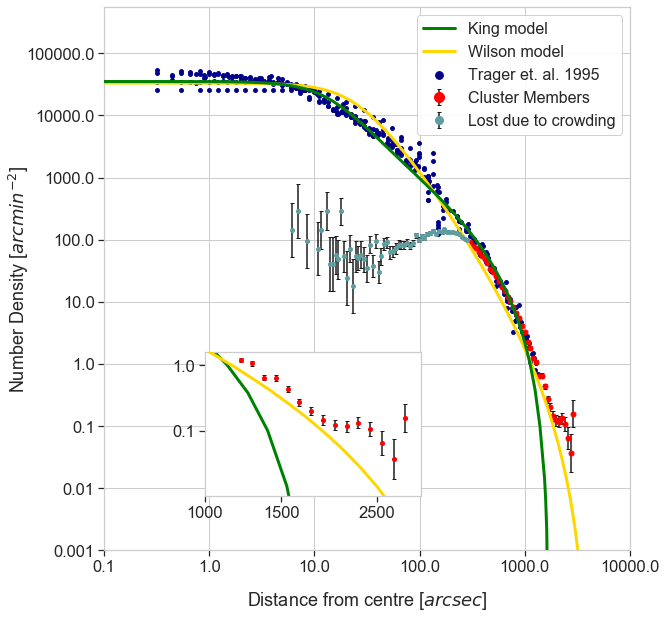

In [28]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
fig.subplots_adjust(left=0.17)

ax.errorbar(log(x1), log(y1), yerr= 0.433*y_err1/y1, fmt="o", ms=5, c='red', ecolor='k', capsize=2,
           label="Cluster Members", zorder=1)

ax.errorbar(log(x2), log(y2), yerr= 0.433*y_err2/y2, fmt="o", ms=4, c='cadetblue', ecolor='k', capsize=2,
           label="Lost due to crowding", zorder=2)

ax.set_ylim(-3, 5.75)
ax.set_xlim(-1,4)

#Trager
ax.scatter(r, nd, c='darkblue', s=15, label = "Trager et. al. 1995", zorder=1)


####King
W0=8.8
k1 = limepy(W0, g=1, verbose=True, project=True)
ax.plot(log(k1.r)+1.17, log(k1.Sigma)+4.25, c='green', lw=3, label="King model", zorder=3)


###Wilson
W0=6.8
k2 = limepy(W0, g=2, verbose=True, project=True)
ax.plot(log(k2.r)+1.4, log(k2.Sigma)+4.25, c='gold', lw=3, label="Wilson model", zorder=2)



ax.tick_params(which='minor', length=5)

ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: f"{10**x}"))

ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: f"{10**x}"))

ax.set_xlabel(r"Distance from centre [$arcsec$]", labelpad=15)
ax.set_ylabel(r"Number Density [$arcmin^{-2}$]", labelpad=-5)


left, bottom, width, height = [0.31, 0.2, 0.3, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.errorbar(log(x3), log(y3), yerr= 0.433*y_err3/y3, fmt="o", ms=4, c='red', ecolor='k', capsize=2,
           label=None)

ax2.plot(log(k1.r)+1.17, log(k1.Sigma)+4.25, c='green', lw=3, label=None, zorder=2)
ax2.plot(log(k2.r)+1.4, log(k2.Sigma)+4.25, c='gold', lw=3, label=None, zorder=3)

ax2.set_ylim(-2,0.2)
ax2.set_xlim(3.0,3.5)
ax2.set_xticks([3,3.1760,3.3979])
ax2.set_xticklabels([1000, 1500, 2500])

ax2.set_yticks([-1.,0.])
#ax2.set_xticklabels([0.1, 1500, 2500])


ax2.yaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: f"{10**x}"))

#ax2.yaxis.set_major_locator(MaxNLocator(1))

ax2.grid(False)



ax.legend(loc=1, markerscale=2, fontsize=16, fancybox=True, framealpha=0.9)
fig.savefig("king.tiff", dpi=500)
plt.show()
plt.close()